In [1]:
# Install Kaggle API
!pip install -q kaggle

# 1. Upload your kaggle.json file
# (Go to Kaggle -> Account -> Create New API Token -> download kaggle.json)
from google.colab import files
print("Upload your kaggle.json file now:")
files.upload()

# 2. Setup Kaggle permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download the specific dataset
print("Downloading dataset...")
!kaggle datasets download -d kushagratandon12/diabetic-retinopathy-balanced

# 4. Unzip it
print("Unzipping...")
!unzip -q diabetic-retinopathy-balanced.zip -d /content/diabetic_data
print("Done! ✅")

Upload your kaggle.json file now:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced
License(s): CC0-1.0
 99% 1.88G/1.90G [00:16<00:00, 250MB/s]
100% 1.90G/1.90G [00:16<00:00, 124MB/s]
Unzipping...
Done! ✅


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import gc

BATCH_SIZE = 8
IMG_SIZE = 224
EPOCHS = 35
NUM_CLASSES = 5
DATA_DIR = "/content/diabetic_data/content/Diabetic_Balanced_Data"

gc.collect()
tf.keras.backend.clear_session()

# DATA PIPELINE
def build_dataset(subset):
    return tf.keras.utils.image_dataset_from_directory(
        os.path.join(DATA_DIR, "train"),
        validation_split=0.2,
        subset=subset,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )

print("Loading Data...")
try:
    train_ds = build_dataset("training")
    val_ds = build_dataset("validation")
except Exception as e:
    print(f"❌ Error finding data: {e}")
    print("⚠️ PLEASE RE-RUN THE KAGGLE DOWNLOAD CELL!")


train_ds = train_ds.shuffle(64).prefetch(buffer_size=2)
val_ds = val_ds.prefetch(buffer_size=2)

# MODEL: CUSTOM SEPARABLE RESNET
# Augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

def build_innovative_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)

    # Initial Block
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Separable Block 1
    prev = x
    x = layers.SeparableConv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual Connection
    residual = layers.Conv2D(64, 1, strides=2, padding='same')(prev)
    x = layers.add([x, residual])

    # Separable Block 2
    prev = x
    x = layers.SeparableConv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(128, 1, strides=2, padding='same')(prev)
    x = layers.add([x, residual])

    # Deep Feature Extraction
    x = layers.SeparableConv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(inputs, outputs)

# TRAINING
model = build_innovative_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

print("Starting Training (T4 Optimized)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save
model.save("diabetic_retinopathy_final.h5")
print("✅ Training Complete & Saved!")

Loading Data...
Found 34792 files belonging to 5 classes.
Using 27834 files for training.
Found 34792 files belonging to 5 classes.
Using 6958 files for validation.
Starting Training (T4 Optimized)...
Epoch 1/35
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 181s 49ms/step - accuracy: 0.3604 - loss: 1.3711 - val_accuracy: 0.3994 - val_loss: 1.3799 - learning_rate: 0.0010
Epoch 2/35
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 171s 49ms/step - accuracy: 0.4383 - loss: 1.2445 - val_accuracy: 0.4365 - val_loss: 1.2953 - learning_rate: 0.0010
Epoch 3/35
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 170s 49ms/step - accuracy: 0.4697 - loss: 1.1886 - val_accuracy: 0.4727 - val_loss: 1.2309 - learning_rate: 0.0010
Epoch 4/35
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 170s 49ms/step - accuracy: 0.4957 - loss: 1.1472 - val_accuracy: 0.4920 - val_loss: 1.1407 - learning_rate: 0.0010
Epoch 5/35
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 202s 49ms/step - accuracy: 0.5126 - loss: 1.1071 - val_accuracy: 0.4986 - val_loss: 1.1712 - learning_rate: 0.0010
Epoch 6/35
348

✅ Training Complete & Saved!


Regenerating Validation Set (Correctly Mixed)...
Found 34792 files belonging to 5 classes.
Using 6958 files for validation.
Processing batches... (This prevents memory crashes)
✅ Predictions Complete!


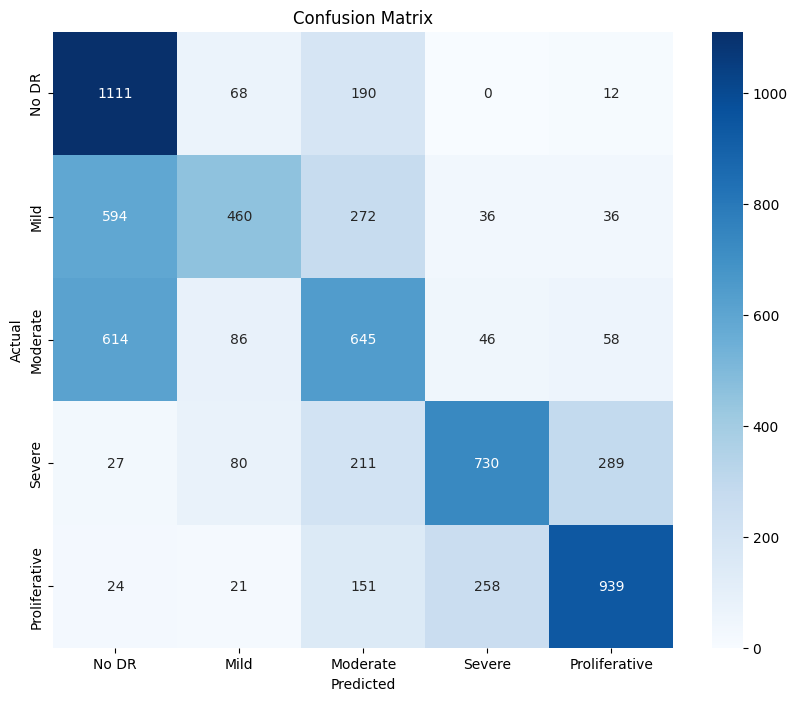


--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

        No DR       0.47      0.80      0.59      1381
         Mild       0.64      0.33      0.44      1398
     Moderate       0.44      0.45      0.44      1449
       Severe       0.68      0.55      0.61      1337
Proliferative       0.70      0.67      0.69      1393

     accuracy                           0.56      6958
    macro avg       0.59      0.56      0.55      6958
 weighted avg       0.59      0.56      0.55      6958



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

print("Regenerating Validation Set (Correctly Mixed)...")

# 1. Load dataset with shuffle=True (MUST match training config to get mixed classes)
val_ds_eval = tf.keras.utils.image_dataset_from_directory(
    "/content/diabetic_data/content/Diabetic_Balanced_Data/train",
    validation_split=0.2,
    subset="validation",
    seed=123,                
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,           
    label_mode='categorical'
)

# 2. Extract Labels and Predictions Batch-by-Batch (RAM Safe)
print("Processing batches... (This prevents memory crashes)")
y_true = []
y_pred = []

for images, labels in val_ds_eval:
    # Get true labels for this batch
    batch_true = np.argmax(labels.numpy(), axis=1)
    y_true.extend(batch_true)

    # Get predictions for this batch
    batch_pred_probs = model.predict(images, verbose=0)
    batch_pred = np.argmax(batch_pred_probs, axis=1)
    y_pred.extend(batch_pred)

print("✅ Predictions Complete!")

# 3. Generate Confusion Matrix
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Generate Classification Report
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=class_names))

Loading data to find an image...
Found 34792 files belonging to 5 classes.
Using 6958 files for validation.
✅ Found Target Layer: separable_conv2d_4
Generating heatmap...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Image saved as grad_cam_result.png


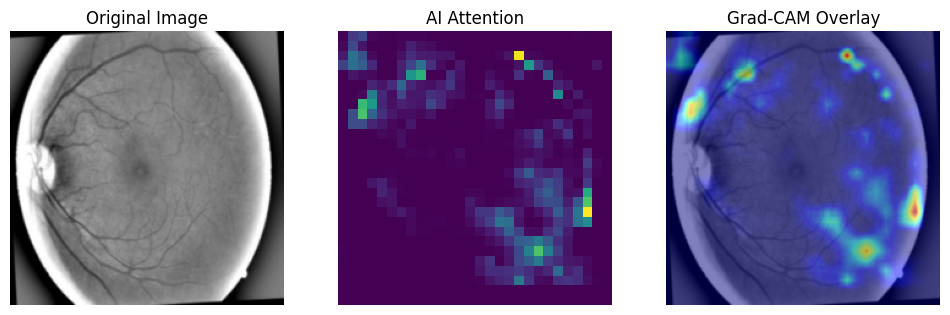

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from google.colab import files

# --- 1. DEFINE GRAD-CAM FUNCTION ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 2. PREPARE DATA ---
# We load just 1 batch of validation data to pick an image from
print("Loading data to find an image...")
eval_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/diabetic_data/content/Diabetic_Balanced_Data/train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True # Shuffle to get a random image
)

# --- 3. AUTO-DETECT LAYER & GENERATE ---
# Find the last convolutional layer automatically
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
        last_conv_layer_name = layer.name
        break
print(f"✅ Found Target Layer: {last_conv_layer_name}")

# Generate and Save
print("Generating heatmap...")
for images, labels in eval_ds.take(1):
    img_array = images[0].numpy().astype("uint8")

    # Create Heatmap
    heatmap = make_gradcam_heatmap(np.expand_dims(img_array, axis=0), model, last_conv_layer_name)

    # Create Visualization
    plt.figure(figsize=(12, 4))

    # Subplot 1: Original
    plt.subplot(1, 3, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis('off')

    # Subplot 2: Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("AI Attention")
    plt.axis('off')

    # Subplot 3: Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_array)
    plt.imshow(cv2.resize(heatmap, (224, 224)), alpha=0.5, cmap='jet')
    plt.title("Grad-CAM Overlay")
    plt.axis('off')

    # Save to disk
    plt.savefig('grad_cam_result.png')
    print("✅ Image saved as grad_cam_result.png")
    plt.show()
    break

# --- 4. DOWNLOAD TO COMPUTER ---
print("Downloading to your computer...")
try:
    files.download('grad_cam_result.png')
except Exception as e:
    print("⚠️ Auto-download failed. Please check the sidebar folder!")